In [1]:
import torch
import numpy as np
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# setup matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    SAVE_PLOTS = False
else:
    matplotlib.use('Agg')
    SAVE_PLOTS = True
import matplotlib.pyplot as plt

In [3]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN

from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [4]:
batch_size = 32
nb_frame = 10

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print("Device:", device)

Device: cpu


In [5]:
CACHE_FOLDER_PATH = "storage/dvs/cache"

    
# def load_data(trail):
# #     if test_run:
# #         trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
#     if trail.startswith('acc'):
#         max_augmentation = 1
#         augmentation = False
#     else:
#         max_augmentation = 2 if trail == 'train' else 1
#         augmentation = True
    
#     trail = trail.replace('acc_', '')
#     return batchify(
#         trail,
#         DATASET_FOLDER_PATH,
#         CACHE_FOLDER_PATH,
#         condition_limit=['natural'],
#         batch_size=batch_size,
#         augmentation=augmentation,
#         max_augmentation=max_augmentation,
#         frame=nb_frame
#     )

original_size = 128
for __xb_test, __yb_test in batchify(
    'test',
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

original_size = 128
for __xb_train, __yb_train in batchify(
    'train',
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

_hist = {i:0 for i in range(12)}
for i in __yb_train:
    _hist[i] += 1
max_value = max(_hist.values())

aug_xb = []
aug_yb = []
for i in range(12):
    idx = np.where(__yb_train == i)[0][0]
    to_add = max_value - _hist[i]
    for _ in range(to_add):
        aug_yb.append(i)
        aug_xb.append(__xb_train[idx, :, :, :])


__yb_train = np.concatenate([__yb_train, np.array(aug_yb)])
__xb_train = np.concatenate([__xb_train, np.array(aug_xb)])
        

def load_data(trail):
    trail = trail.replace('acc_', '')
    c_xb = __xb_train if trail == 'train' else __xb_test
    c_yb = __yb_train if trail == 'train' else __yb_test
    
    
    begin = 0
    end = begin + batch_size
    while end <= c_yb.shape[0]:
        yield c_xb[begin:end, :, :, :], c_yb[begin:end]
        begin = end
        end = begin + batch_size
        
print(__xb_train.shape)
print(__yb_train.shape)
print(__xb_test.shape)
print(__yb_test.shape)

(396, 10, 64, 64)
(396,)
(128, 10, 64, 64)
(128,)


pre-processing dataset: 12
pre-processing dataset: 4


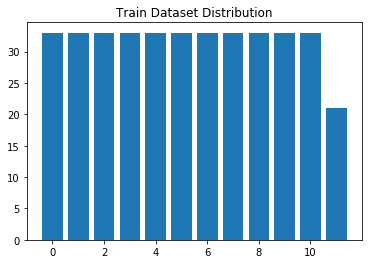

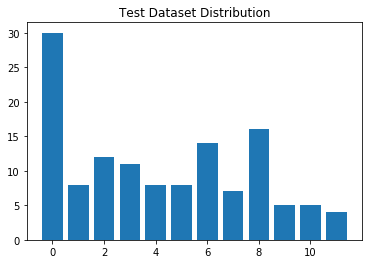

In [6]:
# calculate train dataset size
train_hist = {i:0 for i in range(12)}
test_hist = {i:0 for i in range(12)}
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    for i in y_batch:
        train_hist[i] += 1
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    for i in y_batch:
        test_hist[i] += 1
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

plt.bar(list(train_hist.keys()), list(train_hist.values()))
plt.title('Train Dataset Distribution')
plt.show()
plt.bar(list(test_hist.keys()), list(test_hist.values()))
plt.title('Test Dataset Distribution')
plt.show()

In [7]:
def plot_one_batch(network, batch_id=0):
    for xb, yb in load_data('test'):
        break
    network.plot_one_batch(xb, yb, batch_id)

Network Summery: I(1x64x64) => C3(16,k3) => P(2) => mean(12)
Layer 0: average number of spikes=0.0394
Layer 1: average number of spikes=0.0679


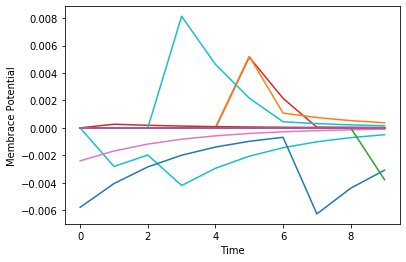

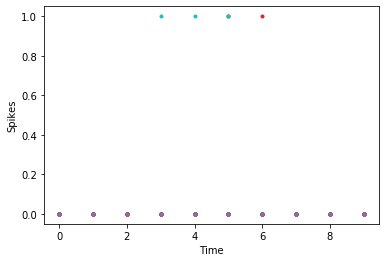

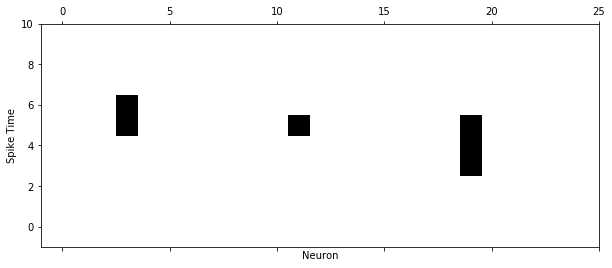

<Figure size 2160x1440 with 0 Axes>

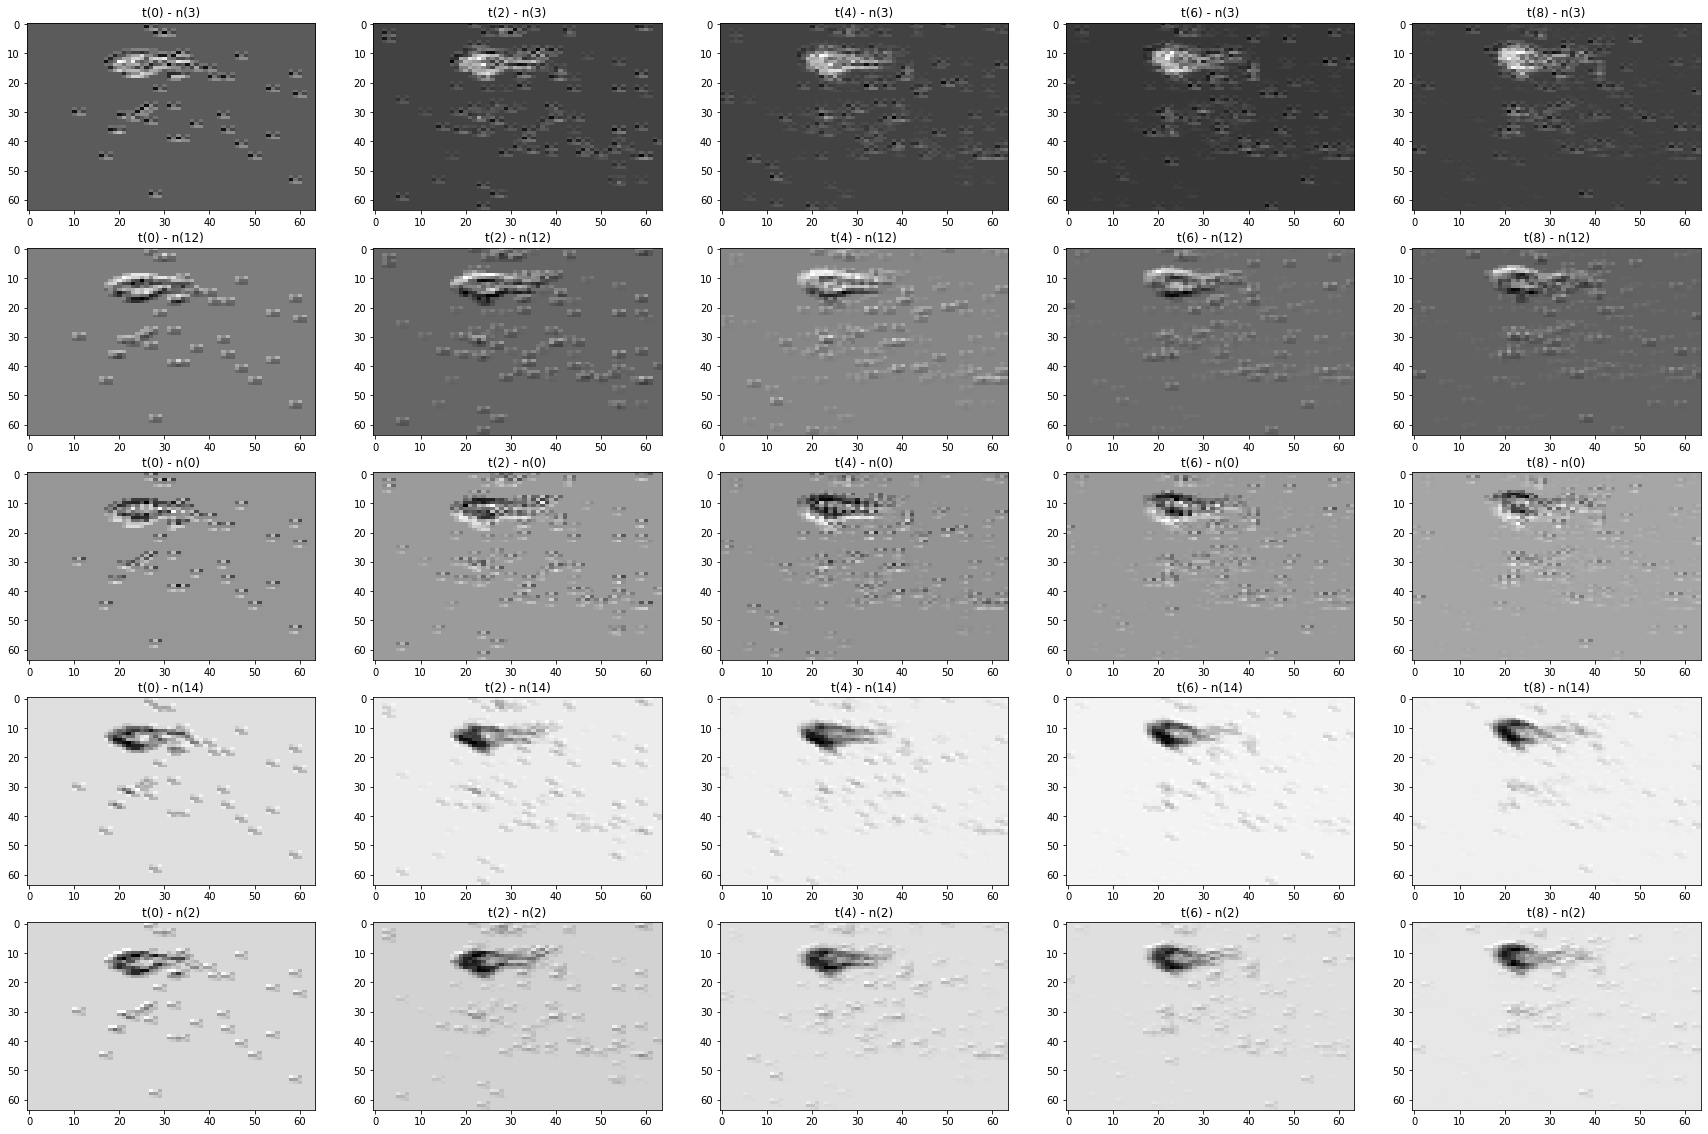

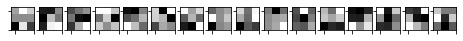

Layer 2: average number of spikes=0.1602


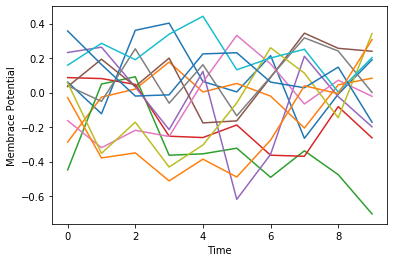

In [8]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector
# network.notifier = notify # FIXME

network.add_conv3d(
    input_shape=(64,64),
    
    output_channels=16,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2))

# network.add_conv3d(    
#     output_channels=128,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))

# network.add_conv3d(    
#     output_channels=256,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))


# network.add_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=0.8,
#     lateral_connections=False,
# )

network.add_readout(
    output_shape=12,
    time_reduction="mean",

    w_init_mean=0.0,
    w_init_std=0.8
)

network.compile()


print('Network Summery:', network.serialize_to_text())
plot_one_batch(network)

In [9]:
lr=0.00001
weight_decay=0.00001
epochs=10

with open('./logs/results.log', 'a+') as f:
    opt = RAdam(network.get_trainable_parameters(lr, weight_decay))
    #     opt = torch.optim.SGD(network.get_trainable_parameters(lr, weight_decay), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_' if SAVE_PLOTS else None)

network.save('./logs/save_network.net')
# network.load('./logs/save_network.net')


Layer 0: average number of spikes=0.0394
Layer 1: average number of spikes=0.0679


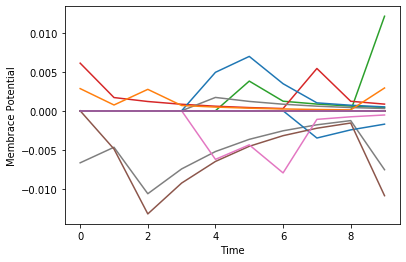

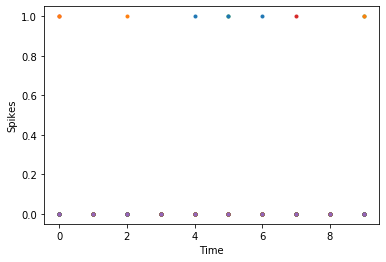

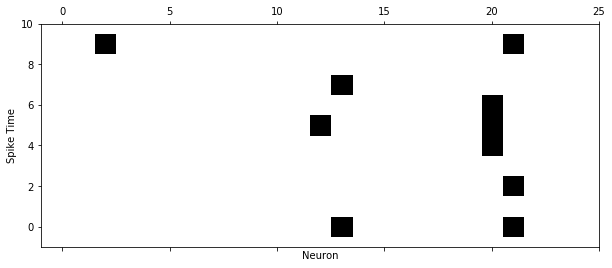

<Figure size 2160x1440 with 0 Axes>

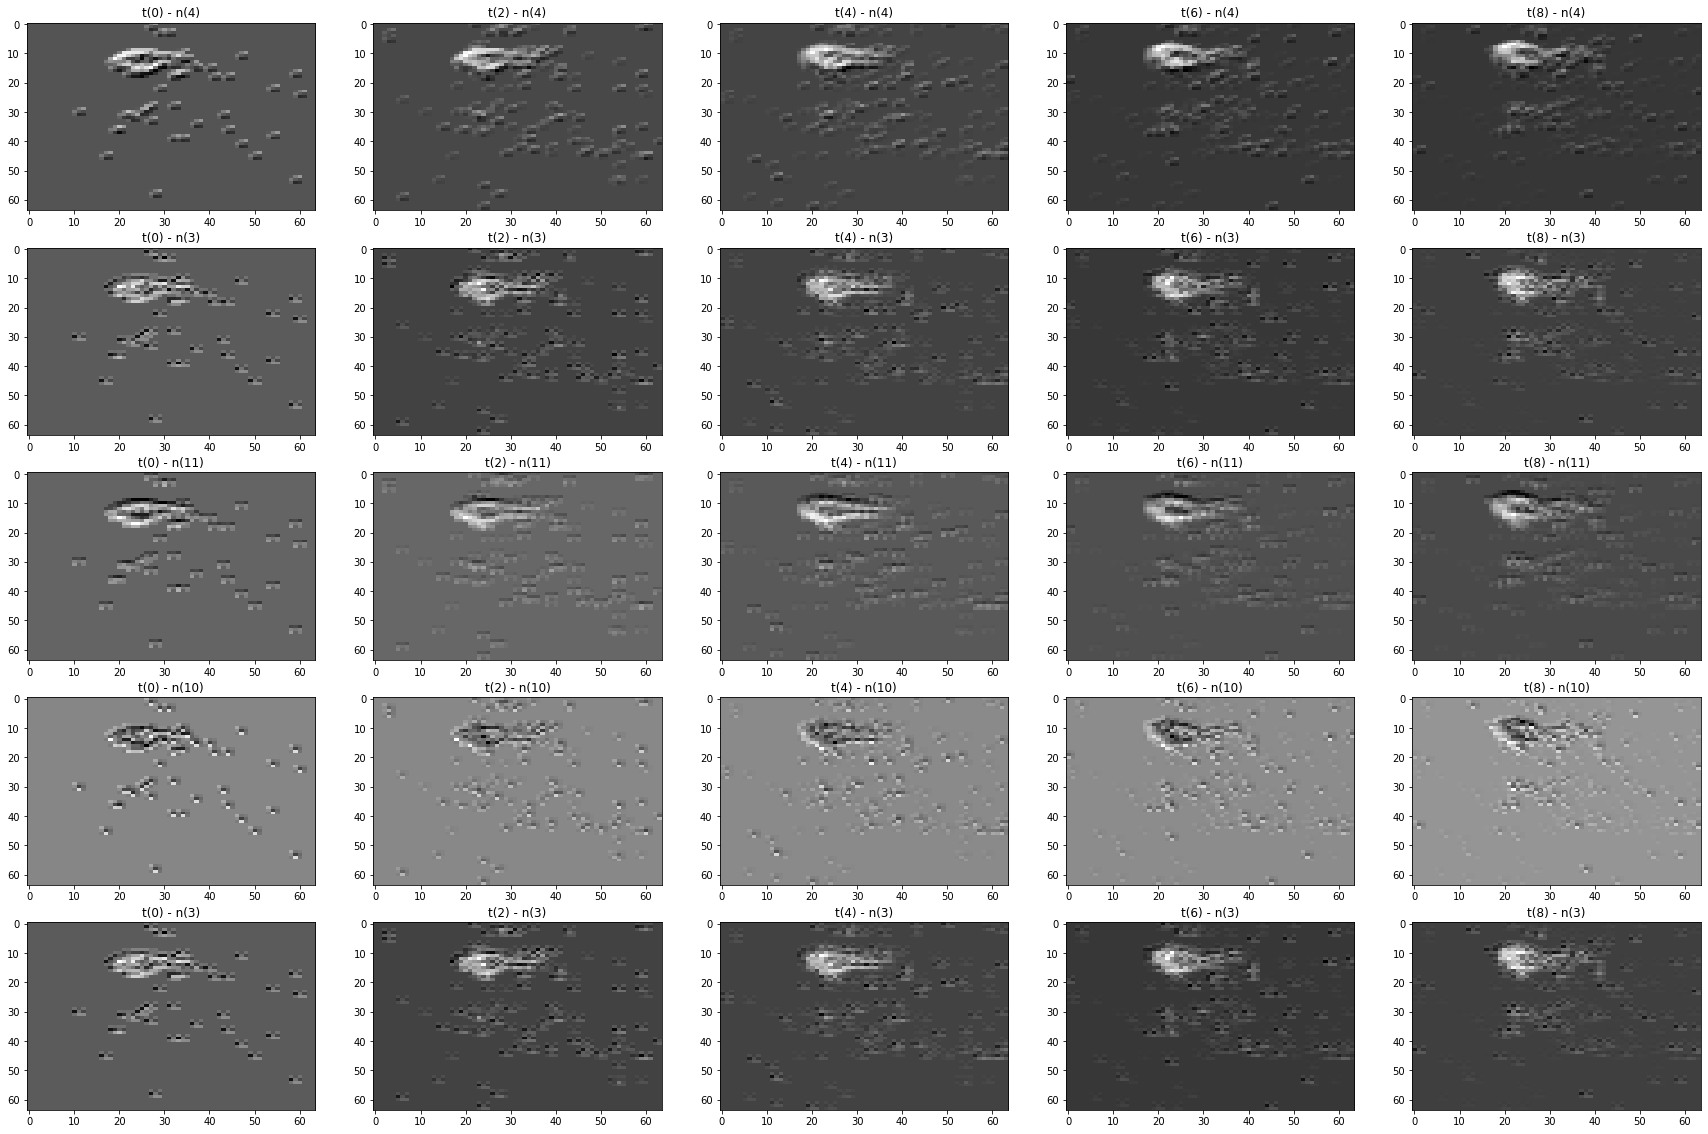

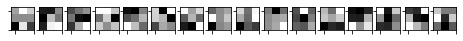

Layer 2: average number of spikes=0.1602


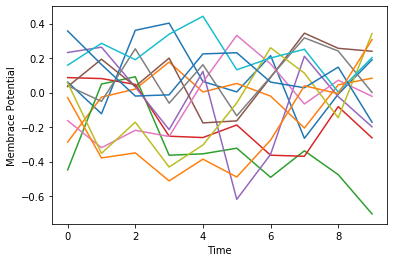


----------------------------------------
Final Train Accuracy=10.16%
Final Test Accuracy=7.03%


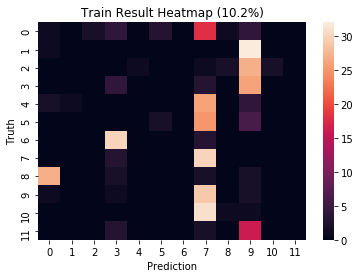

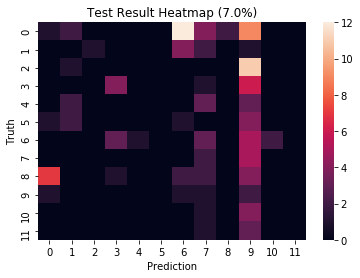

In [10]:
network.load_last_checkpoint()
plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/truth_' if SAVE_PLOTS else None
)